In [669]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns


In [670]:
path="C:\\Users\\jonah\\Documents\\DataScienceBlogpostProject\\data"
os.chdir(path)

# The Seattle Airbnb Dataset

This is data published by Airbnb, a service where hosts can rent out properties and rooms to visitors, on units in Seattle from January 2016 to January 2017. It consists of three linked datasets. The only one I use is `calendar.csv`, which includes the variables

- `listing_id`: the unique identification number of a given listing
- `date`: in YYYY-MM-DD format
- `available`: with `t` for available, and `f` if the unit was unavailable, by date
- `price`: in USD, $____.__ format

`price` has nan values for dates when the given unit is unavailable. 

I'm interested in answering a few questions. 

1. Which months are the busiest?
2. How do prices rise or fall throughout the year?
3. Do individual listings change price, or does the entry and exit of units cause prices to change?

# Question 1: Which months are the busiest?

I'm first interested in what the data trend looks like over time. Are there more listings every month as new hosts enter the market? Does it vary strongly by season?

In [671]:
cal_df = pd.read_csv("calendar.csv")

`cal_df` is a dataframe of all listings, whether they're available for each day of the year, and their price if so.

Are they marked by whether they're booked? Doesn't look like it; `available` is just if they can be booked at all. 

In [672]:
# turning `available` into a boolean:
cal_df_tf = cal_df
cal_df = cal_df.replace("t", True)
cal_df = cal_df.replace("f", False)
# turning price to float
cal_df["price"] = cal_df["price"].replace({'\$': '', '\,': ''}, regex=True)
cal_df["price"] = pd.to_numeric(cal_df["price"])
cal_df["date"] = pd.to_datetime(cal_df["date"])

Visualizing data is always a good first step to spot any abnormalities or interesting trends. I'll see how listings and prices vary throughout the year.

Text(0.5, 1.0, 'Fail 2')

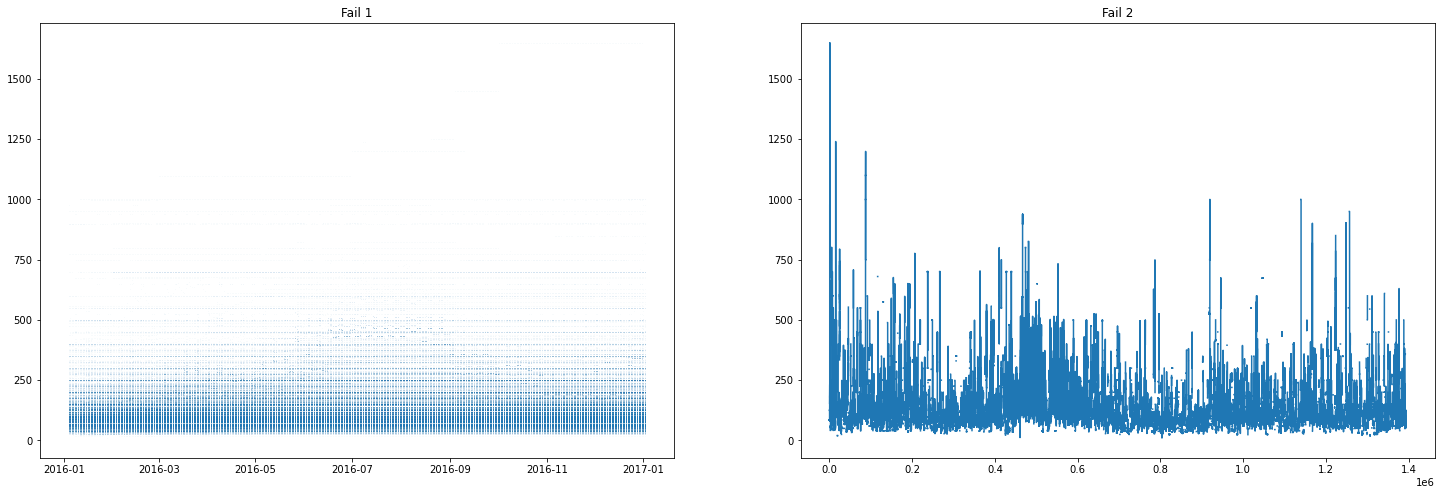

In [673]:
fig, ax = plt.subplots(1, 2, figsize = (25, 8))
# first trying a scatter plot
ax[0].scatter(cal_df["date"], cal_df["price"], s=0.0001)
ax[0].set_title("Fail 1")
# or maybe a line plot?
ax[1].plot(cal_df["price"])
ax[1].set_title("Fail 2")

Well, that's not very informative!

In [674]:
print(cal_df["price"].min())
print(cal_df["price"].max())

10.0
1650.0


Looks like we've got a very price wide range. I doubt the values are distributed evenly over [10, 1650]. I'm going to split the dataframe up into those equal to or less than $500, and those above. $500 is hardly cheap, but sounds reasonable as an upper bound to the normal range for something like a large house. 

In [675]:
expensive_df = cal_df[cal_df["price"] > 500]
cheap_df = cal_df[cal_df["price"] <= 500]
print(len(expensive_df))
print(len(cheap_df))

11959
922583


In a histogram of all prices, it's very hard to make out any meaningful pattern because of the long right tail - a very small number of extremely high prices. 

As we can see above, there are 922583 entries for prices at $500 or below - still hardly cheap! Compare that to the mere 11959 samples over $500. However, with the maximum price of $1650, this spreads the price range out so wide the histogram becomes useless.

Text(0.5, 1.0, 'Fig 3: Histogram of Seattle AirBnb Prices [limit: >$500]')

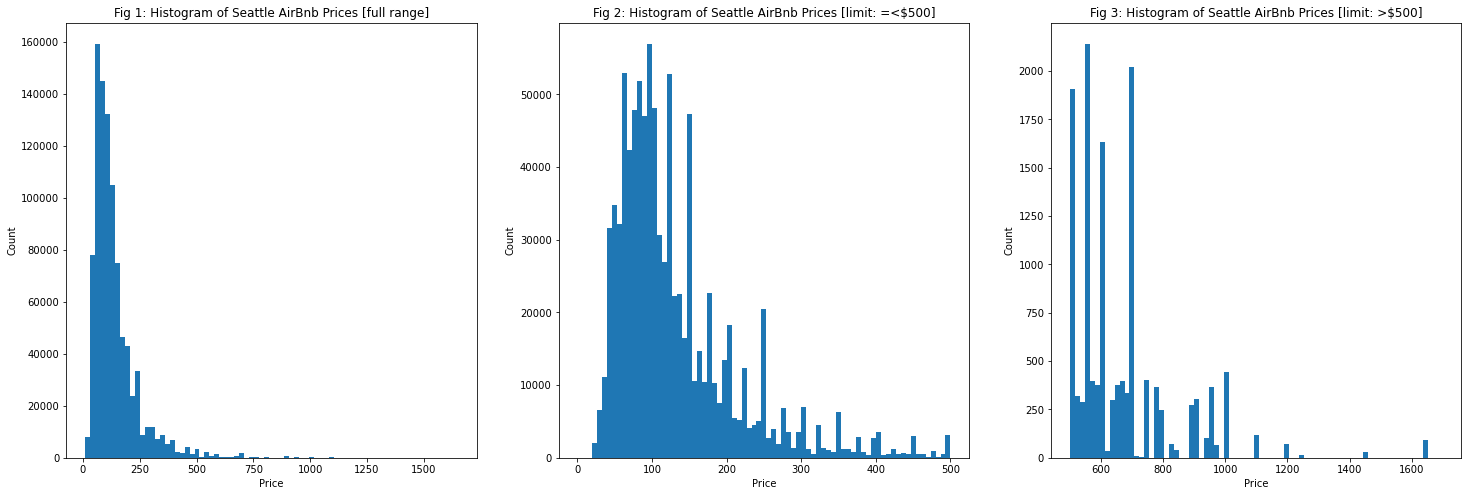

In [676]:
fig, ax = plt.subplots(1, 3, figsize = (25,8))

ax[0].hist(cal_df["price"], bins = 75)
ax[0].set_xlabel("Price")
ax[0].set_ylabel("Count")
ax[0].set_title("Fig 1: Histogram of Seattle AirBnb Prices [full range]")

ax[1].hist(cal_df["price"], bins = 75, range = [0, 500])
ax[1].set_xlabel("Price")
ax[1].set_ylabel("Count")
ax[1].set_title("Fig 2: Histogram of Seattle AirBnb Prices [limit: =<$500]")

ax[2].hist(cal_df["price"], bins = 75, range = [500, 1700])
ax[2].set_xlabel("Price")
ax[2].set_ylabel("Count")
ax[2].set_title("Fig 3: Histogram of Seattle AirBnb Prices [limit: >$500]")

In [677]:
print(cal_df["price"].mean())
print(cal_df["price"].std())

137.94485855103355
105.06287002526753


This is borne out in Fig 1, where even 75 bins still leaves it very hard to make out any pattern in the important core of prices below $250. 

Fig 2 is better. We see evidence of clumping, likely at increments of $5. The peak of the distribution is around $100, with a longer right tail, and no prices below $10.

Fig 3 should be read carefully - its y-axis values peak slightly above 2000, rather than suggesting a return to the same heights as Fig 2 shows at the peak of the density range. 

What we can conclude from these values is that the distribution is roughly normal with a mean of $138 and standard deviation of 105. Howver, it's bounded above 0, with a long right tail, and clear bunching at certain nominal values, likely multiples of 5. 

With the bounded dataset, can we get a useful idea of how listings are spread throughout the year?

Text(0.5, 1.0, 'Fail 5: Scatter of Seattle AirBnb Prices by Dates [limit: >$500]')

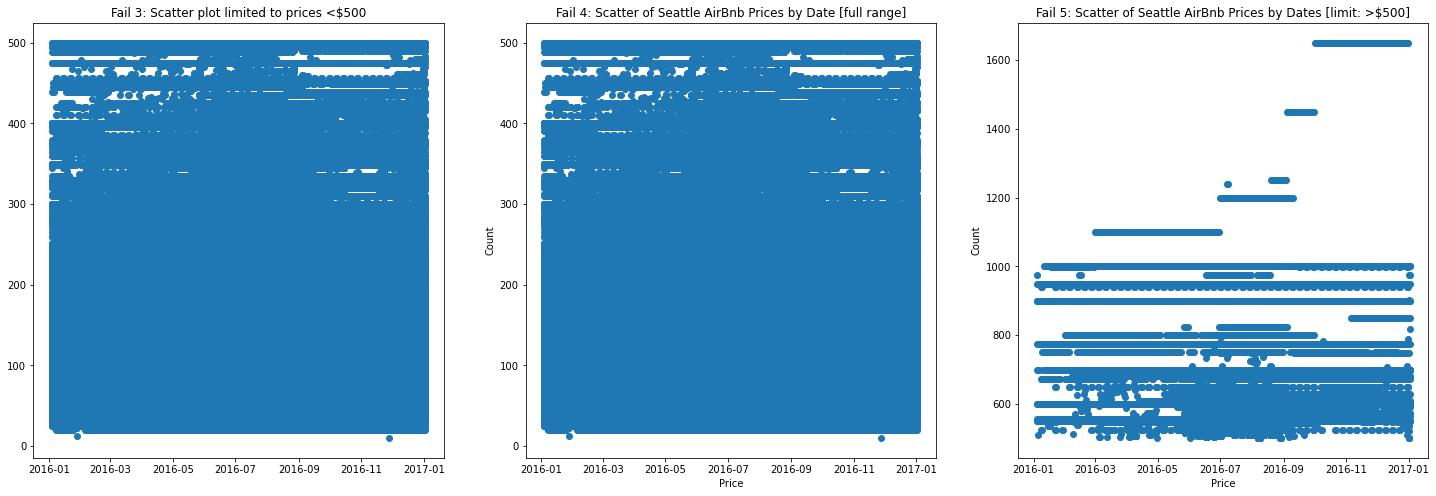

In [678]:
fig, ax = plt.subplots(1, 3, figsize = (25,8))

# revisiting scatter plot with `cheap_df`
ax[0].scatter(x = cheap_df["date"], y=cheap_df["price"])
ax[0].set_title("Fail 3: Scatter plot limited to prices <$500")

ax[1].scatter(x = cheap_df["date"], y=cheap_df["price"])
ax[1].set_xlabel("Price")
ax[1].set_ylabel("Count")
ax[1].set_title("Fail 4: Scatter of Seattle AirBnb Prices by Date [full range]")

ax[2].scatter(x = expensive_df["date"], y = expensive_df["price"])
ax[2].set_xlabel("Price")
ax[2].set_ylabel("Count")
ax[2].set_title("Fail 5: Scatter of Seattle AirBnb Prices by Dates [limit: >$500]")


Still no. These are incomprehensible; simply too dense to make sense of. I'm going to try a simple bar plot by month.

In [679]:
# extracting month and year from overall date, then grouping by year-month so Jan 16 and Jan 17 aren't combined
cal_df["month"] = cal_df["date"].dt.month
cal_df["year"] = cal_df["date"].dt.year
count_df = cal_df.groupby(["year", "month"]).count()

Text(0.5, 1.0, 'Fig 5: Listings by month: By Listed Price')

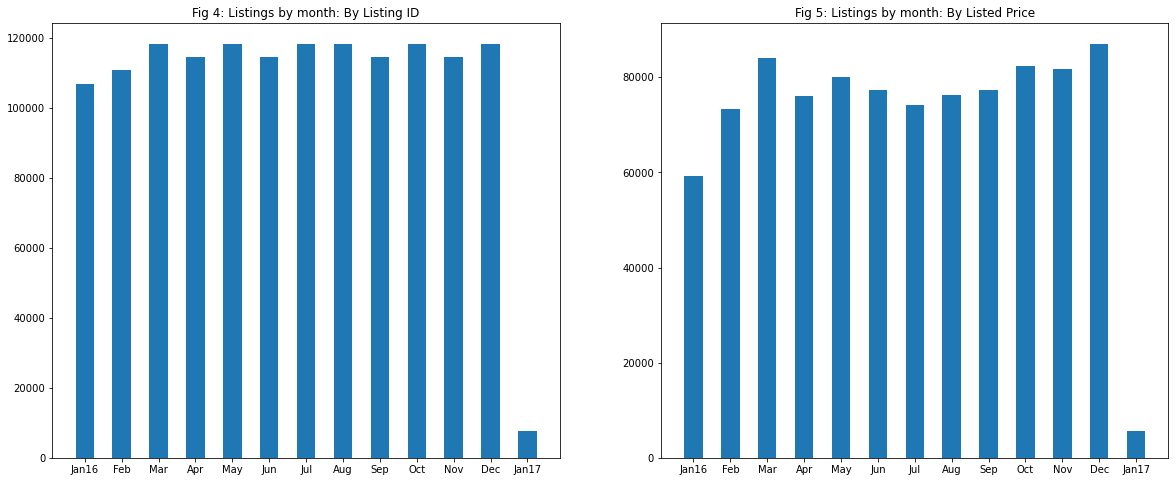

In [680]:
count_df_noindex = count_df.reset_index()

fig, ax = plt.subplots(1, 2, figsize = (20,8))

months = ["Jan16", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec", "Jan17"]
ax[0].bar(x = months, height = count_df_noindex["listing_id"], width=0.5)
ax[0].set_title("Fig 4: Listings by month: By Listing ID")

ax[1].bar(x = months, height = count_df_noindex["price"], width=0.5)
ax[1].set_title("Fig 5: Listings by month: By Listed Price")

So, there's not a clear upward trend in listings. It looks like there's a collapse in January 2017 - most likely they don't have the whole month covered.

Listing by price is more variable - prices are only shown when the listings are available. Fig 5 is more informative than Fig 4 - units only enter the plot if they have a listed price, and therefore are available, so Fig 5 is much better for showing what's on the market than Fig 4. It varies more by month, and values are overall lower. The plunge in January 2017 is still clearly visible.

Could the January 2017 collapse be simply due to the month not being fully covered?

In [681]:
cal_df["date"].max()

Timestamp('2017-01-02 00:00:00')

Yep! We've only got one day of the new year. No wonder it's so low!

# Question 2: How do prices vary over time?

We've seen that listing numbers (which we can think of as supply) are highest over the summer. This may be because demand for vacation housing is high in summer, so high prices bring more hosts onto the market, but could also be that many hosts are going on vacation themselves and want to rent out their homes, which could push prices down. I'm interested in seeing what the data actually shows. 

This will be looking specifically at the overall price level. In question 3, I'm going to see if individual listings see their prices change noticeably over time. 

In [682]:
cal_df_unavailable = cal_df[cal_df["available"] == False]
cal_df_available = cal_df[cal_df["available"] == True]
avail_df_gb = cal_df_available.groupby("month").mean()

Text(0.5, 1.0, 'Fig 6: Average price by month')

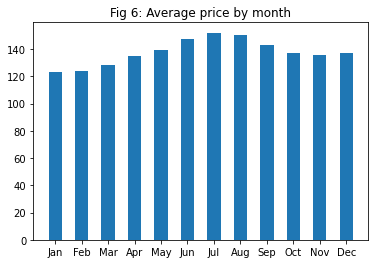

In [683]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.bar(x = months, height = avail_df_gb["price"], width=0.5)
plt.title("Fig 6: Average price by month")

There is an overall increase from January to December, but the interesting change is in the seasons. Prices peak in June, July, and August. By Autumn they've fallen slightly, but still to a higher level than the spring. 

I'm going to run a very simple linear model to find the slope - what rate do we expect these prices to rise yearly?

In [684]:
import statsmodels.api as sm

month_range = np.arange(1, 13, 1)

linear_reg_df = {"price": avail_df_gb["price"], "intercept": 1, "month": month_range}
linear_reg_df = pd.DataFrame(data=linear_reg_df)
linear_reg_df_exog = linear_reg_df.drop("price", axis=1)

### 1. Basic Month-level linear regression

In [685]:
# Month Model
month_model = sm.OLS(linear_reg_df["price"], linear_reg_df_exog)
month_model_result = month_model.fit()
print(month_model_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     3.842
Date:                Wed, 19 Oct 2022   Prob (F-statistic):             0.0784
Time:                        14:51:52   Log-Likelihood:                -41.592
No. Observations:                  12   AIC:                             87.18
Df Residuals:                      10   BIC:                             88.15
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    128.7879      5.222     24.663      0.0

c:\Users\jonah\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


A linear regression assumes the variables input as explanatory variables (`month` in our case) affect the outcome variable (`price`) linearly. It then computes a line of this relation with a slope to minimize the distance from the line and observed data points. Simply, it finds the best fit for the data. 

Model 1 is very simple - it accounts for the average level with the `intercept` variable, then takes the slope of a best-fit line over the `month` variable. 

It suggests an average increase in price of $1.39 per month, with a p-value of 0.078. This p-value is the probability we would get a value as or more extreme than we observed if the true values do not actually change by month. In most academic publications, a p-value of 0.05 is seen as the minimum for an effect size to be trusted, and even then, marginally significant effects are viewed with suspicion.

The issue here is that grouping by month drastically reduced the number of observations we have to work with. I'm going to remake the dataset instead working by days. We'll have far more observations, and a lower standard error.

### 2. Day-level linear regression

In [686]:
cal_df_available["day"] = cal_df_available["date"].dt.day
day_df = cal_df_available[["price", "day"]]
day_df["intercept"] = 1
day_df_exog = day_df.drop("price", axis=1)

C:\Users\jonah\AppData\Local\Temp\ipykernel_3428\3851851190.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cal_df_available["day"] = cal_df_available["date"].dt.day
C:\Users\jonah\AppData\Local\Temp\ipykernel_3428\3851851190.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_df["intercept"] = 1


In [687]:
# Day Model 1
day_model = sm.OLS(day_df["price"], day_df_exog)
day_model_result = day_model.fit()
print(day_model_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.048
Date:                Wed, 19 Oct 2022   Prob (F-statistic):              0.306
Time:                        14:51:53   Log-Likelihood:            -5.6759e+06
No. Observations:              934542   AIC:                         1.135e+07
Df Residuals:                  934540   BIC:                         1.135e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
day            0.0126      0.012      1.024      0.3

I'm not printing the summary, but the model finds a positive but insignificant effect of `day` on `price`.

When the price clearly did rise over the course of the year, and we'd expect it to, thanks to inflation, the problem is probably that the model is underspecified. We observed `price` has an upside-down U-shape when graphed against `month`. If I add an exponential transformation of the day variable, this may make the model fit much better.

### 3. Day-level linear and quadratic regression

In [688]:
day_df["day_squared"] = day_df["day"]**2
day_df_exp_exog = day_df.drop("price", axis=1)

C:\Users\jonah\AppData\Local\Temp\ipykernel_3428\1430650972.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_df["day_squared"] = day_df["day"]**2


In [689]:
day_model_2 = sm.OLS(day_df["price"], day_df_exp_exog)
day_model_2_result = day_model_2.fit()
print(day_model_2_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.524
Date:                Wed, 19 Oct 2022   Prob (F-statistic):             0.0108
Time:                        14:51:53   Log-Likelihood:            -5.6759e+06
No. Observations:              934542   AIC:                         1.135e+07
Df Residuals:                  934539   BIC:                         1.135e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
day            -0.1267      0.051     -2.495      

Both `day` and `day_squared` are statistically significant. The model suggests a change of X days causes an $0.13X decrease in price from the linear day variable, but an $0.044X^2 increase from the squared variable.

For example, say we go from day 0 to day 30. The linear variable causes a $3.8 drop in price, while the exponential variable causes a $3.96 increase in price, netting a $0.16 overall increase. 

This fits there being occasional reductions in price in the short run while increasing overall. Interstingly, though, the exponential variable here is the positive one, when the plot showed the data having a downward-sloping curve from the highest priced months in the summer. 

### 4. Month-level linear+quadratic regression 

Now, just quickly running a nonlinear model on months, to get the R-squared values.

In [690]:
nonlinear_month_df = linear_reg_df
nonlinear_month_df["month_squared"] = nonlinear_month_df["month"]**2
nonlinear_month_df_exog = nonlinear_month_df.drop("price", axis=1)

month_model_2 = sm.OLS(nonlinear_month_df["price"], nonlinear_month_df_exog)
month_model_2_result = month_model_2.fit()
#print(month_model_2_result.summary())

print("The adjusted R-squared value is 0.785.")

The adjusted R-squared value is 0.785.


# Visualizing Linear and Quadratic Month Models

Putting the regressions side by side, we see the quadratic has a much better fit to the data. The R2 value represents what portion of the data's variation the models explain - and it's also much higher for the quadratic model. Considering the small number of features available, I doubt we can get a better fit for the data without overfitting by adding too many polynomial degrees.

I'm going to use two styles of plot. One is Seaborn's `regplot`, which plots a regression best fit line to a given number of polynomial degrees. The other is a manual slope of the linear and squared month coefficients I found in model 4. As we'll see, this matches the second Seaborn model - I did it just to make sure `regplot` wasn't basing its degree-2 model off just month squared.

In [691]:
month_numbers = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]

def make_slope(num_list):
    slope = []
    for num in num_list:
        output = 9.6968*num - 0.6389*num**2 + 109.4073
        slope.append(output)
    return slope

lin_quad_slope = make_slope(month_numbers)
lin_quad_slope_array = np.asarray(lin_quad_slope)

Text(2, 170, 'Adj R2: 0.785')

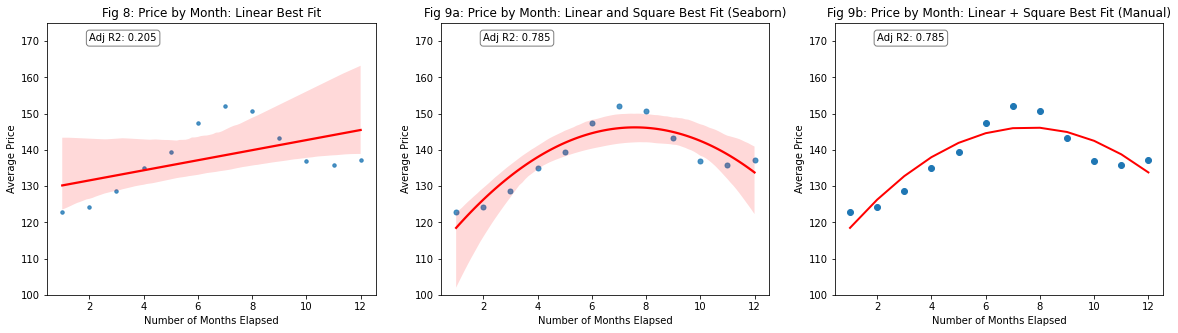

In [692]:
fig, ax = plt.subplots(1, 3, figsize = (20,5))

sns.regplot(x = month_range, y = avail_df_gb["price"], line_kws={"color": "red"}, scatter_kws={"s": 12}, ax=ax[0])
ax[0].set_title("Fig 8: Price by Month: Linear Best Fit")
ax[0].set_xlabel("Number of Months Elapsed")
ax[0].set_ylabel("Average Price")
ax[0].set_ylim(100, 175)


sns.regplot(x = month_range, y = avail_df_gb["price"], line_kws={"color": "red"}, scatter_kws={"s": 25}, order=2, ax=ax[1])
ax[1].set_title("Fig 9a: Price by Month: Linear and Square Best Fit (Seaborn)")
ax[1].set_xlabel("Number of Months Elapsed")
ax[1].set_ylabel("Average Price")
ax[1].set_ylim(100, 175)

ax[2].scatter(x = month_range, y = avail_df_gb["price"])
ax[2].plot(month_range, lin_quad_slope_array, color="r", linewidth=2)
ax[2].set_title("Fig 9b: Price by Month: Linear + Square Best Fit (Manual)")
ax[2].set_xlabel("Number of Months Elapsed")
ax[2].set_ylabel("Average Price")
ax[2].set_ylim(100, 175)
#sns.regplot(x = month_range, y = avail_df_gb["price"], line_kws={"color": "red"}, scatter_kws={"s": 12}, order=2)

props = dict(boxstyle="round", facecolor="white", alpha=0.5)
text0 = "Adj R2: 0.205"
ax[0].text(2, 170, text0, bbox=props)
text1 = "Adj R2: 0.785"
ax[1].text(2, 170, text1, bbox=props)
text0 = "Adj R2: 0.785"
ax[2].text(2, 170, text0, bbox=props)

As mentioned above, I was uncertain whether Seaborn's `regplot` function does just a square (x*x) curve, or both first- and second-order polynomials when its `order` argument equals 2. Coding up a manual regression slope in Fig 9b, we can see it matches the Seaborn one in 9a, so both match the linear+square month-level regression. It's clear from visual inspection that Fig 9 fits the data much better than Fig 8. 

Adjusted R2 is a metric describing what proportion of the data's variation the model we use explains, from 0 (explaining nothing) to 1 (perfectly matching every data point). Higher values suggest a better model, but are vulnerable to overfitting - creating a model excessively calibrated to a specific sample, that will fail when applied to new data. Fig 8's 0.205 isn't impressive, though it's not nothing. Fig 9's 0.785 is a good value. It shows we're explaining about 78.5% of the data's variation. Visually, it overestimates about as much as it underestimates, and would need pretty sharp deviations to match the points it misses. It fits about as closely as we can expect from such a simple dataset, with relatively few features to train a model on. 

# Warnings

Firstly, this model is chiefly a predictive one. If someone gives us a month in 2016, we can estimate the average price of an AirBnB that month. If we assume this is a causal model showing a high-price summer season and a low-price winter season (likely due to varying demand levels), that's the meaning we're inferring. It may be a reasonable explanation, but for all we know, it could just be that more expensive units are put on the market in the summer and so prices rise, or another explanation entirely. It takes more investigation to conclusively rule out the other interpretations.

Secondly, we cannot just extend the predictions out into 2017 (or back into 2015) with the slope coefficients estimated. That would suggest an all-time price peak in summer 2016, and prices falling out from that point - past $0 once we go far enough! I don't think summer 2016 was that special! These are called "out of sample" predictions, and they're very inadvisable with linear regression. 

Given multiple years, it would likely be better to design a regression with seasonal or monthly dummy variables (increasing/decreasing the value by a fixed amount depending on the month/season) to handle within-year price variation, and a linear time trend for long-run price inflation year to year. 

# Question 3: Are individual listings changing price?

If the overall price level is changing with time, it could just be because the composition of the listing pool is changing. I'm interested in whether individual listings change price over the roughly 12 months of the dataset. 

To analyze this, I will do the following:


1. I can take fixed effects for those entering each month, and then see if a linear (and linear+quadratic) day trend still suggests rising prices.

2. Do more AirBNB hosts enter in the busy months, at higher prices?

### 1. Entries by month

In [693]:
indiv_df = cal_df[cal_df["available"] == True]
indiv_entry_df = indiv_df.groupby("listing_id").min()
indiv_entry_df.head()

,date,available,price,month,year
listing_id,,,,,
3335,2016-02-29,True,120.0,1,2016
4291,2016-01-04,True,82.0,1,2016
5682,2016-01-11,True,42.0,1,2016
6606,2016-01-04,True,90.0,1,2016
7369,2016-01-14,True,85.0,1,2016


In [694]:
# finding the `available` (i.e. on the market) units, and then their first date on the market, which is taken as their market entry dates
indiv_df = cal_df[cal_df["available"] == True]
indiv_entry_df = indiv_df.groupby("listing_id").min()
indiv_entry_df.head()

# creating entry dates for each observation
entry_date = indiv_entry_df.reset_index()
entry_date = entry_date[["listing_id", "date"]]
entry_date["entry"] = entry_date["date"]
entry_date.drop("date", axis=1, inplace=True)

# creating dataframe stating the price, day, and month the unit entered
month_entry_df = indiv_df.merge(entry_date, on="listing_id")
month_entry_df["month_entered"] = month_entry_df["entry"].dt.month
month_entry_df["day"] = month_entry_df["date"].dt.day

In [695]:
# creating variables for entry in each month, against baseline of entering market in january
month_entry_df["feb"] = 0
month_entry_df["mar"] = 0
month_entry_df["apr"] = 0
month_entry_df["may"] = 0
month_entry_df["jun"] = 0
month_entry_df["jul"] = 0
month_entry_df["aug"] = 0
month_entry_df["sep"] = 0
month_entry_df["oct"] = 0
month_entry_df["nov"] = 0
month_entry_df["dec"] = 0

# assigning values of 1 for if entering market in given month
month_entry_df.loc[month_entry_df["month_entered"] == 2, "feb"] = 1
month_entry_df.loc[month_entry_df["month_entered"] == 3, "mar"] = 1
month_entry_df.loc[month_entry_df["month_entered"] == 4, "apr"] = 1
month_entry_df.loc[month_entry_df["month_entered"] == 5, "may"] = 1
month_entry_df.loc[month_entry_df["month_entered"] == 6, "jun"] = 1
month_entry_df.loc[month_entry_df["month_entered"] == 7, "jul"] = 1
month_entry_df.loc[month_entry_df["month_entered"] == 8, "aug"] = 1
month_entry_df.loc[month_entry_df["month_entered"] == 9, "sep"] = 1
month_entry_df.loc[month_entry_df["month_entered"] == 10, "oct"] = 1
month_entry_df.loc[month_entry_df["month_entered"] == 11, "nov"] = 1
month_entry_df.loc[month_entry_df["month_entered"] == 12, "dec"] = 1

In [696]:
month_entry_df

,listing_id,date,available,price,month,year,entry,month_entered,day,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
0,241032,2016-01-04,True,85.0,1,2016,2016-01-04,1,4,0,0,0,0,0,0,0,0,0,0,0
1,241032,2016-01-05,True,85.0,1,2016,2016-01-04,1,5,0,0,0,0,0,0,0,0,0,0,0
2,241032,2016-01-13,True,85.0,1,2016,2016-01-04,1,13,0,0,0,0,0,0,0,0,0,0,0
3,241032,2016-01-14,True,85.0,1,2016,2016-01-04,1,14,0,0,0,0,0,0,0,0,0,0,0
4,241032,2016-01-18,True,85.0,1,2016,2016-01-04,1,18,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
934537,10208623,2016-01-06,True,87.0,1,2016,2016-01-04,1,6,0,0,0,0,0,0,0,0,0,0,0
934538,10208623,2016-01-07,True,87.0,1,2016,2016-01-04,1,7,0,0,0,0,0,0,0,0,0,0,0
934539,10208623,2016-01-10,True,87.0,1,2016,2016-01-04,1,10,0,0,0,0,0,0,0,0,0,0,0
934540,10208623,2016-01-11,True,87.0,1,2016,2016-01-04,1,11,0,0,0,0,0,0,0,0,0,0,0


In [697]:
# splitting off `price` as outcome variable, and `day`, `intercept`, and month entered variables as explanatory variables
month_entry_df_price = month_entry_df["price"]
month_entry_df_exog = month_entry_df.drop(["listing_id", "date", "available", "month", "year", "month_entered", "entry", "price"], axis=1)
month_entry_df_exog["intercept"] = 1

In [698]:
# just showcasing the explanatory dataframe
month_entry_df_exog

,day,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,intercept
0,4,0,0,0,0,0,0,0,0,0,0,0,1
1,5,0,0,0,0,0,0,0,0,0,0,0,1
2,13,0,0,0,0,0,0,0,0,0,0,0,1
3,14,0,0,0,0,0,0,0,0,0,0,0,1
4,18,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
934537,6,0,0,0,0,0,0,0,0,0,0,0,1
934538,7,0,0,0,0,0,0,0,0,0,0,0,1
934539,10,0,0,0,0,0,0,0,0,0,0,0,1
934540,11,0,0,0,0,0,0,0,0,0,0,0,1


#### Entry Month Fixed Effects Model

In [699]:
entry_month_model = sm.OLS(month_entry_df_price, month_entry_df_exog)
entry_month_model_result = entry_month_model.fit()
print(entry_month_model_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     254.8
Date:                Wed, 19 Oct 2022   Prob (F-statistic):               0.00
Time:                        14:51:56   Log-Likelihood:            -5.6744e+06
No. Observations:              934542   AIC:                         1.135e+07
Df Residuals:                  934529   BIC:                         1.135e+07
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
day            0.0114      0.012      0.929      0.3

#### What's the interpretation on this model?

- The `intercept` variable removes the average across all samples. 
- The month variables each account for the average of those entering in each month (once the intercept is removed)

So `day` and `day_sq` show how prices change over time beyond these. `day` is negative, `day_sq` is positive; at first glance they're ambiguous. I can find the point at which they balance out, however, by taking -0.1243d + 0.043d^2 = 0 and solving for d

So, at d=2.89, the effect from these is 0; beyond this it is positive. So by the third day we'd already expect prices to be rising. 

Both of these variables are significant at the 0.05 level, a decent rule of thumb for statistical significance (their effect being reliable). Most of the month effect variables are also significant, suggesting that those who enter in different months do have meaningfully different prices. So it would appear that both possible explanations for the variation in price throughout the year have solid evidence. The units entering the market in the summer have higher prices, but even accounting for this, units' prices rise over the course of the year, suggesting individual prices rise as well. 




### Do more enter the market in specific months?

Related to the supposed summer busy season, I'd like to check if it's true there are a lot of summer entries, by visualizing entries by month.

In [700]:
month_entries = month_entry_df.drop(["date", "available", "price", "month", "year", "entry"],axis=1)
#  totalling up how many entered each month, and taking a cumulative total of entries by each month
month_groups = month_entries.groupby("month_entered").count()["listing_id"]
month_groups_cum = month_groups[1:].cumsum()


Text(0.5, 1.0, 'Cumulative entries by month: January included')

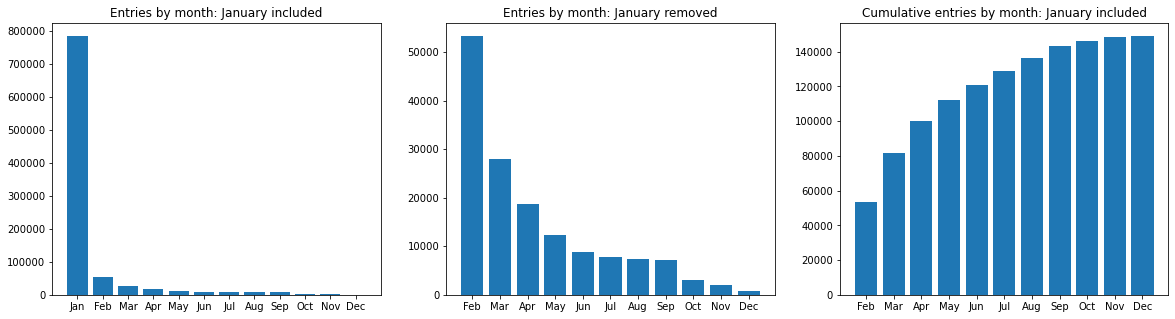

In [701]:
fig, ax = plt.subplots(1, 3, figsize = (20,5))

ax[0].bar(x=months, height=month_groups)
ax[0].set_title("Entries by month: January included")

ax[1].bar(x=months[1:], height=month_groups[1:])
ax[1].set_title("Entries by month: January removed")

ax[2].bar(x=months[1:], height=month_groups_cum)
ax[2].set_title("Cumulative entries by month: January included")

The stratospheric January value is almost certainly an artifact from January including all units that entered the market prior to 2016. Removing it for the second plot shows that there isn't a new surge of units entering the market in summer - entries fall over the course of the year. Cumulative entries in plot 3 does show that by summer, most of the units that have entered the market that year have already done so - June has just over 120,000, of the nearly 150,000 that will enter. While cumulative entries rises every month, this doesn't mean total number on the market must rise too - it falls in later months as the number of market exits surpasses entries in the fall and winter. 